# 0. Data Load

In [8]:
from pandas_datareader import data as pdr
import FinanceDataReader as fdr
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

yf.pdr_override()
data = pdr.get_data_yahoo("005930.KS")

[*********************100%***********************]  1 of 1 completed


특정 주식에 관한 정보를 확인할 수 있다.

In [9]:
fdr.StockListing('KOSPI')

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,66500,2,-200,-0.30,66000,66700,65800,6097529,403961256600,396990539575000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,528000,2,-12000,-2.22,534000,538000,527000,106741,56652011000,123552000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,116800,1,2000,1.74,112600,118700,111800,2098463,243442747300,85030676232000,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,771000,2,-1000,-0.13,764000,780000,764000,18639,14379913000,54875154000000,71174000,STK
4,005490,KR7005490008,POSCO홀딩스,KOSPI,,549000,2,-4000,-0.72,552000,561000,543000,553062,304954613000,46429605270000,84571230,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,014915,KR7014911002,성문전자우,KOSPI,,5650,2,-130,-2.25,5610,5670,5610,115,646130,3390000000,600000,STK
946,001525,KR7001521004,동양우,KOSPI,,5300,2,-10,-0.19,5350,5350,5300,139,738150,3273974300,617731,STK
947,002787,KR7002782001,진흥기업2우B,KOSPI,,10980,2,-40,-0.36,11070,11070,10950,783,8596920,3236991840,294808,STK
948,000227,KR7000222000,유유제약2우B,KOSPI,,9900,2,-70,-0.70,9960,9960,9900,65,643680,3223044000,325560,STK


코스피에 등록된 모든 주식 정보를 확인할 수 있다.

# 1. EDA(DDA + EDA + CDA)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5929 entries, 2000-01-04 to 2023-08-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5929 non-null   float64
 1   High       5929 non-null   float64
 2   Low        5929 non-null   float64
 3   Close      5929 non-null   float64
 4   Adj Close  5929 non-null   float64
 5   Volume     5929 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 324.2 KB


None 값이 없음을 확인했다.

### 1) 요일 체크
계절성 모델인 SARIMA를 이용하기 때문에 요일 데이터의 빈도가 치우쳐져 있는 경우 좋지 않은 결과가 나올 것이라 생각했다. 따라서 이를 확인한다. 

Date
Thursday     1199
Tuesday      1189
Friday       1185
Wednesday    1181
Monday       1175
Name: count, dtype: int64


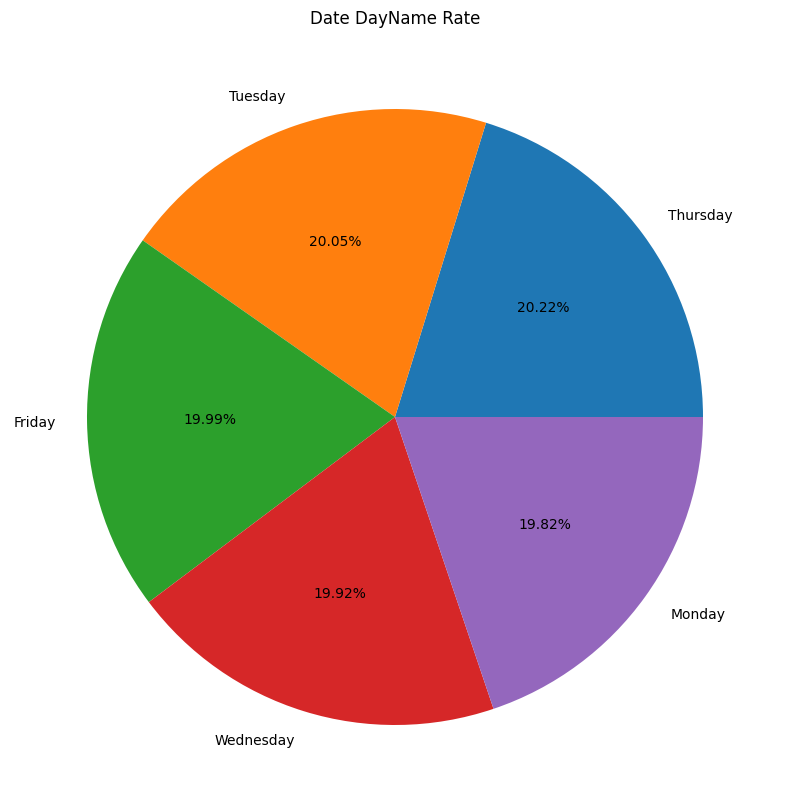

In [11]:
dayname = pd.Series(pd.to_datetime(data.index)).dt.day_name()
print(dayname.value_counts())

dayname.value_counts().plot.pie(autopct='%.2f%%', figsize = (10, 10))
plt.title('Date DayName Rate')
plt.ylabel('')
plt.show()

요일 별로 빈도가 균일함을 알 수 있다.   
토요일과 일요일의 정보는 없음을 확인했다.

In [12]:
import re

dataTemp = data.reset_index()
dataTemp['Year'] = dataTemp['Date'].apply(lambda x: int(str(x)[:4]))
dataTemp['Month'] = dataTemp['Date'].apply(lambda x: int(str(x)[5:7]))
dataTemp['Day'] = dataTemp['Date'].apply(lambda x: int(str(x)[8:10]))
dataTemp = dataTemp[['Year', 'Month', 'Day', 'Adj Close', 'Volume', 'Open',	'High',	'Low','Close']]
dataTemp.head()

,Year,Month,Day,Adj Close,Volume,Open,High,Low,Close
0,2000,1,4,4514.580566,74195000,6000.0,6110.0,5660.0,6110.0
1,2000,1,5,4122.972168,74680000,5800.0,6060.0,5520.0,5580.0
2,2000,1,6,4152.526855,54390000,5750.0,5780.0,5580.0,5620.0
3,2000,1,7,4093.416016,40305000,5560.0,5670.0,5360.0,5540.0
4,2000,1,10,4263.360840,46880000,5600.0,5770.0,5580.0,5770.0


날짜를 연도, 달, 일로 쪼개서 나중에 활용하기 좋게 만들었다.

### 2) 상관관계 확인
다중 공선성이 존재하는 경우 모델의 성능이 좋지 않게 된다. 이를 상관관계와 VIF 값을 통해 알아보고 변수들끼리 같이 써도 되는지 확인한다.

           Close    Volume
Close   1.000000 -0.383703
Volume -0.383703  1.000000


c:\Users\chlgu\anaconda3\envs\plotly\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


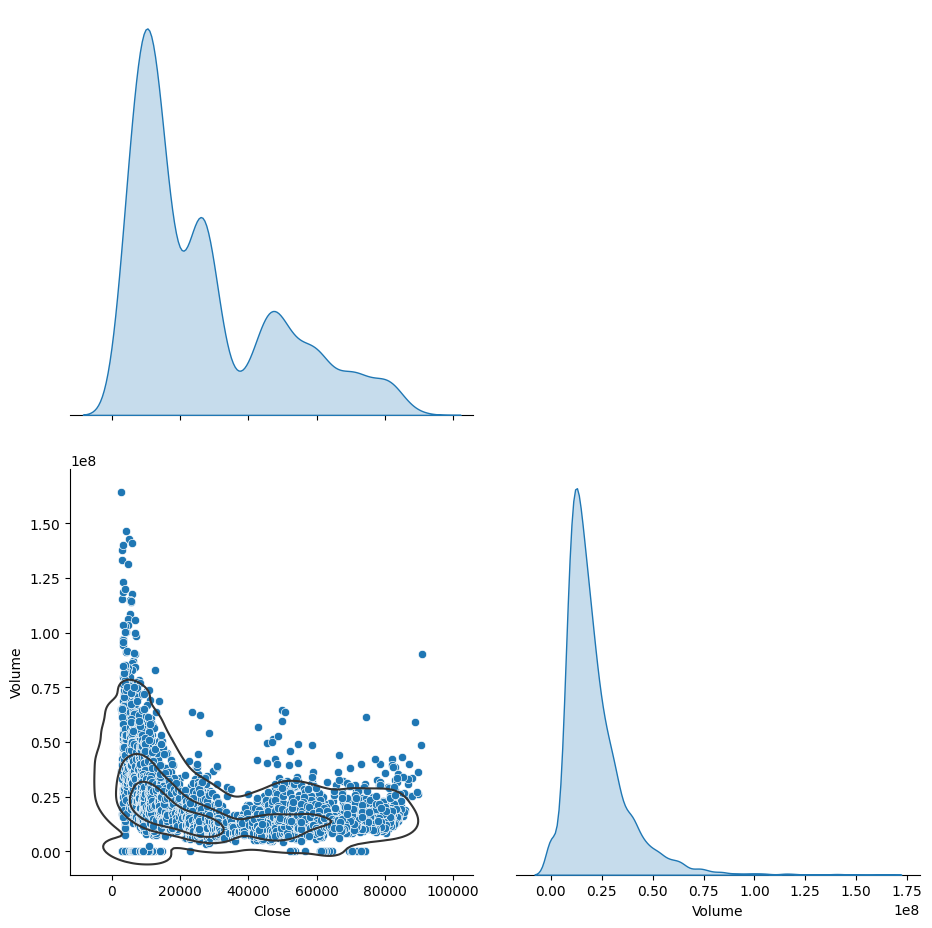

In [13]:
import seaborn as sns
print(dataTemp[['Close' , 'Volume']].corr())

g = sns.pairplot(dataTemp[['Close' , 'Volume']], diag_kind = 'kde', corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
g.fig.set_size_inches(10,10)
plt.show()

이것 만으로는 상관관계를 파악하기 힘들다.   
Close와 Volume이 Skewness가 음수임을 확인할 수 있었다.(분포가 치우쳐짐)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

print('VIF Close :', variance_inflation_factor(dataTemp[['Close' , 'Volume']], 0))
print('VIF Volume :', variance_inflation_factor(dataTemp[['Close' , 'Volume']], 1))

VIF Close : 1.330614483355985
VIF Volume : 1.330614483355984


다중공선성 점수로 VIF를 확인한 결과 10 미만 값에서 아주 작은 값이므로 두 변수는 연관이 없음을 확인했다.   
따라서 두 변수는 같이 써도 된다는 판단을 할 수 있다.

### 3) Transformation
ARMA 모델은 사용하기 위해 분포가 일정하고 평균이 일정해야 한다는 특징이 있다.   
여기서 분포를 일정하게 만들기 위한 방법이 바로 Transformation이다.

In [15]:
import plotly.offline as plyo
import cufflinks as cf

plyo.iplot(
    dataTemp[['Close', 'Volume']].iplot(
            kind='hist',
            subplots=True,
            # bins=15,
            asFigure=True
            ),
    filename='./ply_03'
)

두 변수의 분포를 다시 한 번 히스토그램을 통해 확인해 본다.   
역시나 왼쪽으로 치우쳐진 형태를 띈다.

In [16]:
import numpy as np

plyo.iplot(
    dataTemp[['Close', 'Volume']].apply(np.log).iplot(
            kind='hist',
            subplots=True,
            # bins=15,
            asFigure=True
            ),
    filename='./ply_03'
)

Log Transformation을 통해 데이터의 분포를 정규분포로 만들었다.

### 4) Smoothing

In [17]:
data_close = dataTemp.groupby(['Year', 'Month'])['Close'].sum().reset_index()
data_close['Year_Month'] = data_close['Year'].astype(str) + '-' + data_close['Month'].astype(str)
data_close['Year_Month'] = pd.to_datetime(data_close['Year_Month'])
# test['Year']
data_close = data_close.set_index('Year_Month')
data_close = data_close['Close']
data_close = data_close.iloc[:-1]
data_close = data_close.apply(np.log)
data_close.describe()

count    283.000000
mean      12.919260
std        0.822491
min       11.107810
25%       12.308561
50%       12.905301
75%       13.662240
max       14.424678
Name: Close, dtype: float64

In [18]:
data_volume = dataTemp.groupby(['Year', 'Month'])['Volume'].sum().reset_index()
data_volume['Year_Month'] = data_volume['Year'].astype(str) + '-' + data_volume['Month'].astype(str)
data_volume['Year_Month'] = pd.to_datetime(data_volume['Year_Month'])
# test['Year']
data_volume = data_volume.set_index('Year_Month')
data_volume = data_volume['Volume']
data_volume = data_volume.iloc[:-1]
data_volume = data_volume.apply(np.log)
data_volume.describe()

count    283.000000
mean      19.787555
std        0.506358
min       17.068688
25%       19.393204
50%       19.750080
75%       20.114170
max       21.248222
Name: Volume, dtype: float64

일 별로 확인 할 경우 변동이 너무 심하기 때문에 달 별로 취합해서 확인하기 위해 Smoothing 작업을 수행했다.

### 5) 푸리에 변환을 통한 추세 확인, 계절성 확인 그리고 Differencing
ARMA 모델은 시계열 데이터의 평균이 일정해야 한다고 했다. 즉, 추세가 없어야 한다.   
이 추세를 없애기 위한 방법으로 Differencing 방법이 있다.   
이는 ARIMA 모델에 포함된 방법으로 I가 바로 Differencing을 뜻한다. 이 값을 정하는 법을 확인한다.   

또한 SARIMA 모델을 사용하기 위해 계절성이 있는지도 확인한다.

#### 5-1) 푸리에 변환

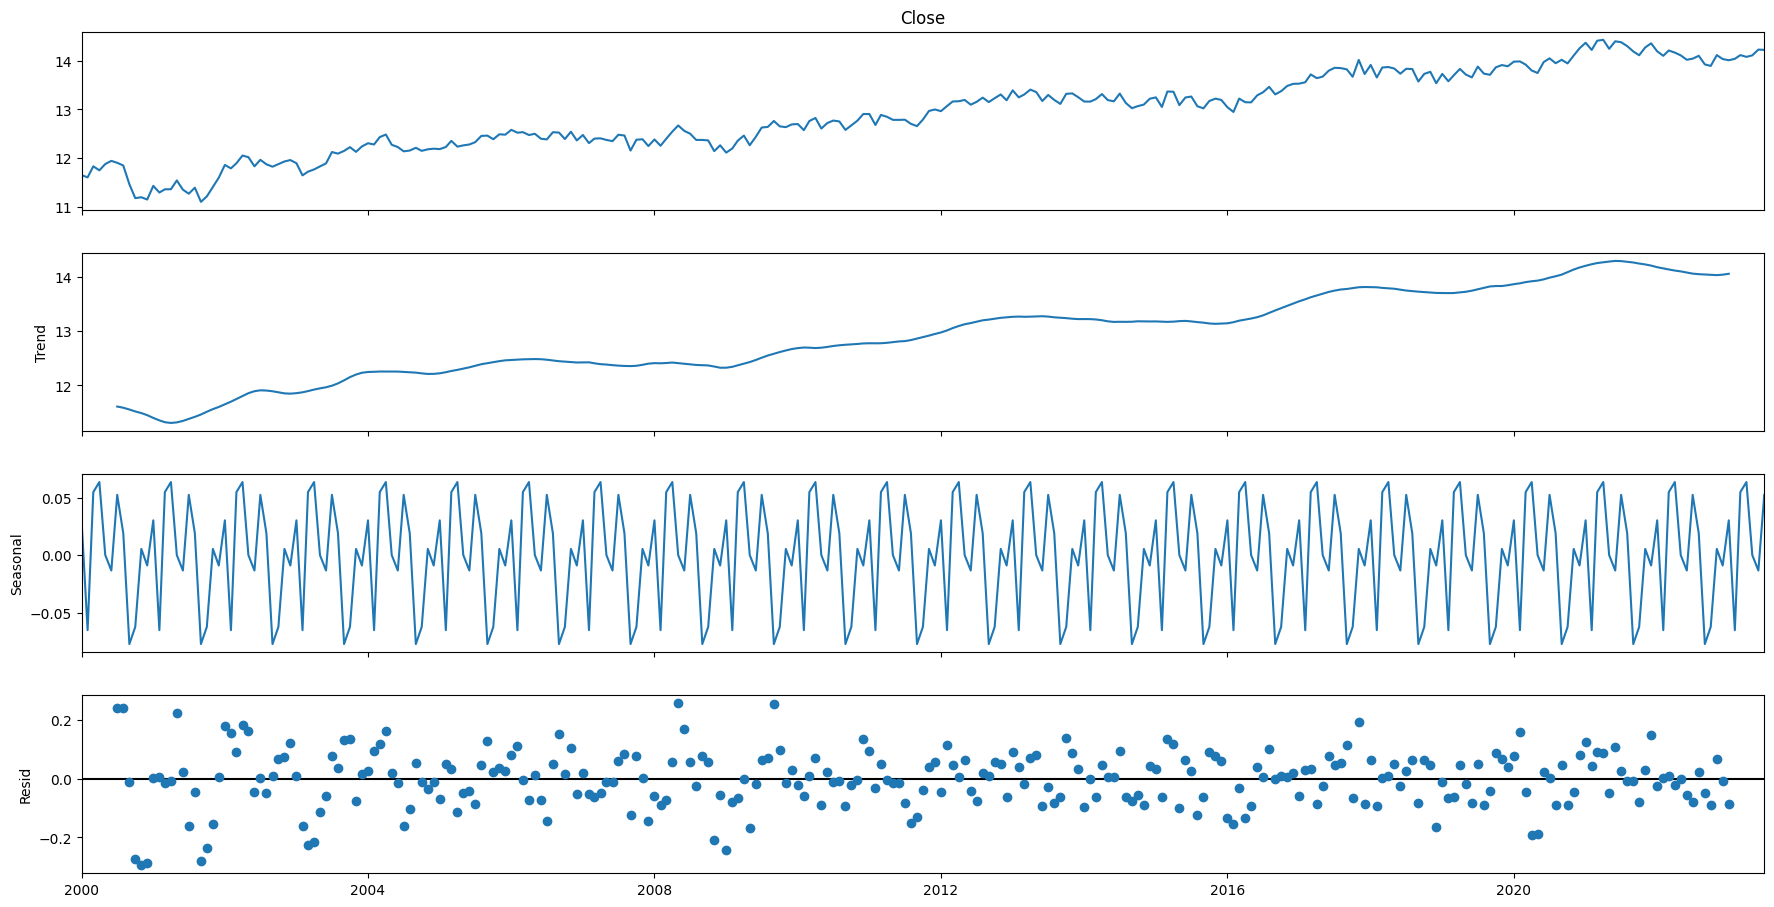

In [19]:
import statsmodels.api as sm

decompostion = sm.tsa.seasonal_decompose(data_close, model = 'addictive', period = 12)
fig = decompostion.plot()
fig.set_size_inches(20, 10)
plt.show()

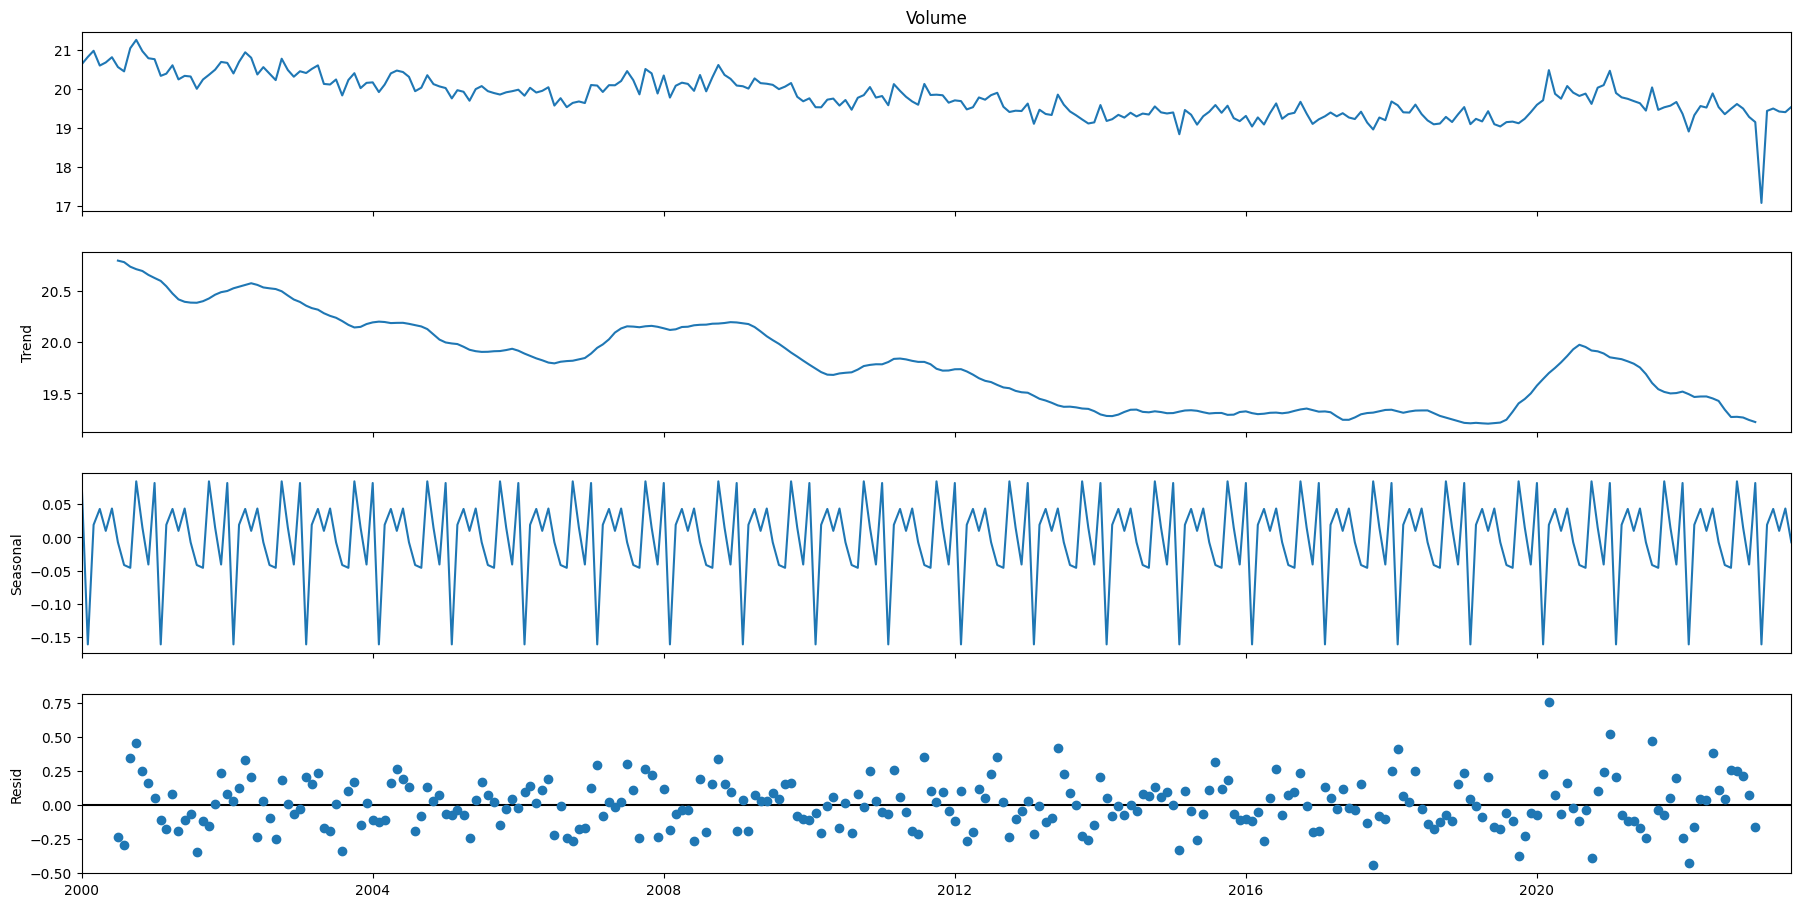

In [20]:
import statsmodels.api as sm

decompostion = sm.tsa.seasonal_decompose(data_volume, model = 'addictive', period = 12)
fig = decompostion.plot()
fig.set_size_inches(20, 10)
plt.show()

두 데이터 모두 추세와 계절성이 있음을 확인할 수 있었다.

#### 5-2) Differencing

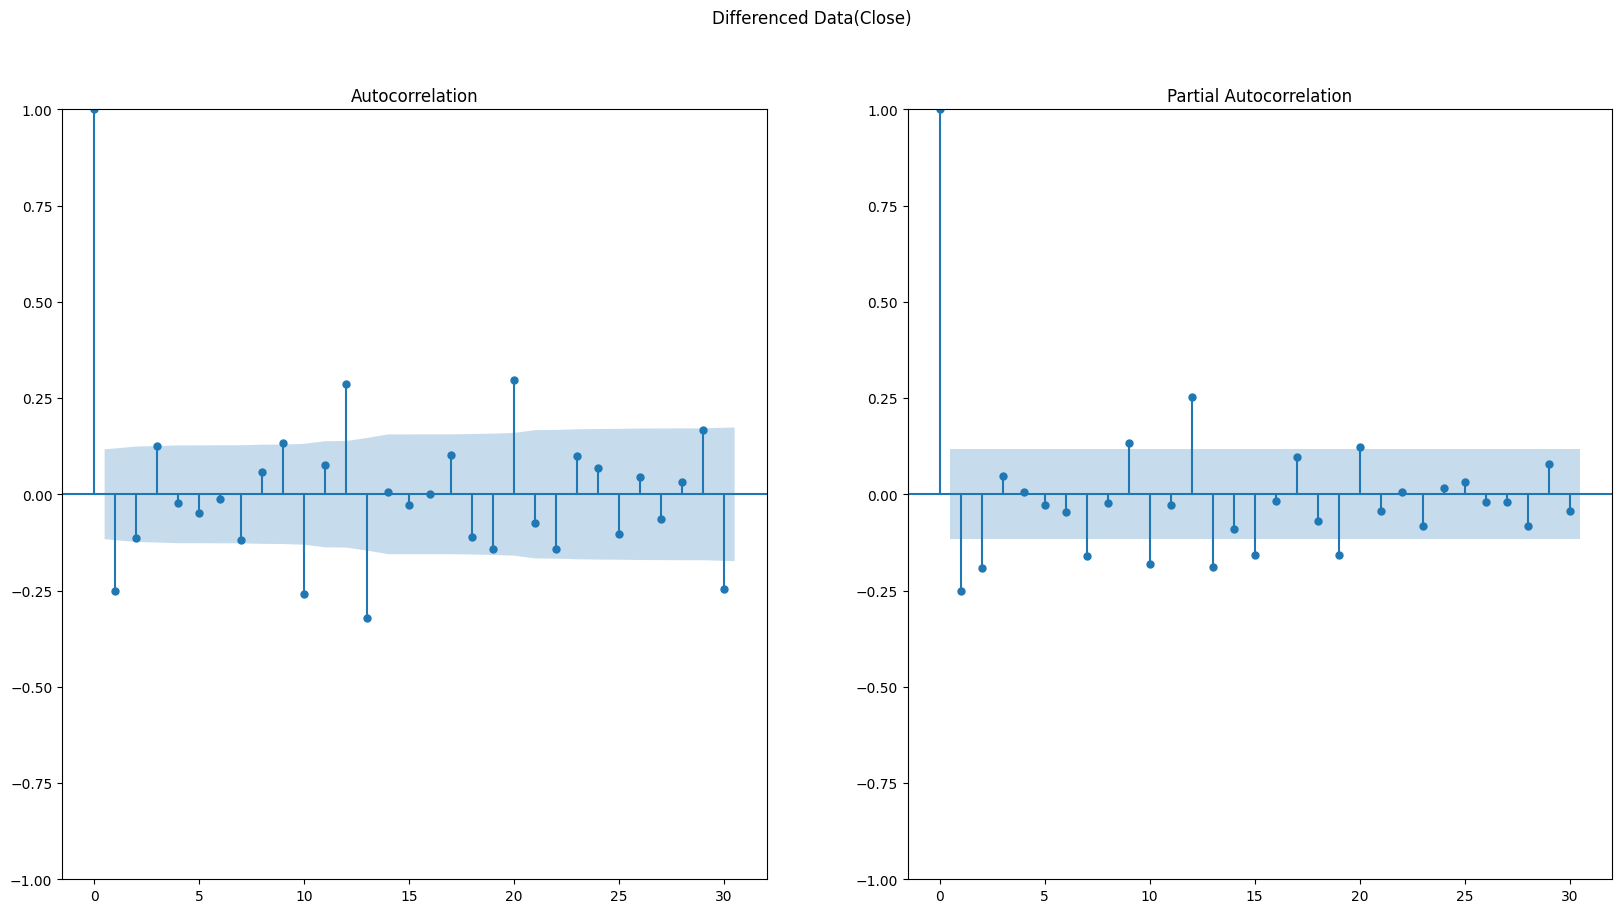

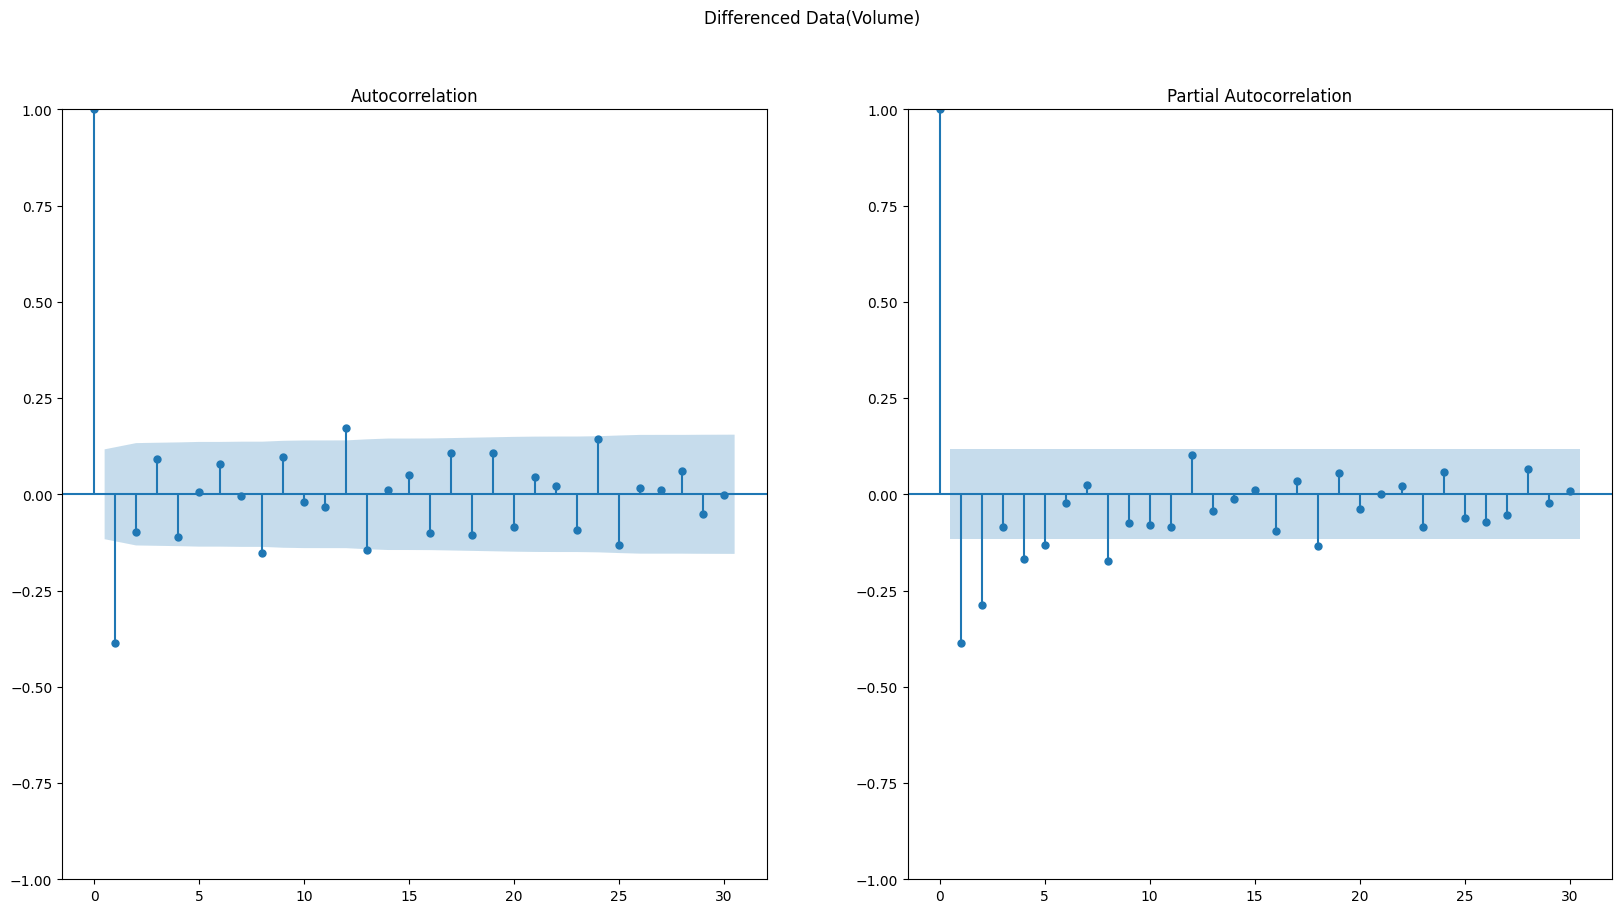

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Differenced Data(Close)')
sm.graphics.tsa.plot_acf(data_close.diff(1).dropna().values.squeeze(), lags=30 , ax = ax[0])
sm.graphics.tsa.plot_pacf(data_close.diff(1).dropna().values.squeeze(), lags=30, ax = ax[1])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Differenced Data(Volume)')
sm.graphics.tsa.plot_acf(data_volume.diff(1).dropna().values.squeeze(), lags=30 , ax = ax[0])
sm.graphics.tsa.plot_pacf(data_volume.diff(1).dropna().values.squeeze(), lags=30, ax = ax[1])
plt.show()

diff 값을 1로 잡고 해본 결과 상당히 그래프가 안정되었음을 확인할 수 있었다.   
또한 Close ACF, PACF 그래프에서 AR값과 MA 값을 확인하고 MA(1)을 사용하는 것이 가장 적합함을 알 수 있었다.


# 3. Modeling & Visualization

### 1) SingleVariate ARIMA

먼저 기본적으로 ARIMA 모델은 단변량 기반 모델이므로 단변량을 확인해본다.

In [22]:
from sklearn.model_selection import train_test_split

train_close_data, test_close_data = train_test_split(data_close, test_size = 0.2, shuffle = False)
train_volume_data, test_volume_data = train_test_split(data_volume, test_size = 0.2, shuffle = False)

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

class Arima_process:
    def __init__(self, order, seasonal_order, bmulti = False,  **kwarg):
        train_close_data, test_close_data = kwarg['train_close'], kwarg['test_close']
        
        if bmulti:
            train_volume_data, test_volume_data = kwarg['train_volume'], kwarg['test_volume']
            model = SARIMAX(endog=train_close_data.values, exog=train_volume_data.values, order=order, seasonal_order=seasonal_order)
            self.sarima_model = model.fit()
            self.prediction = self.sarima_model.get_forecast(len(test_close_data), exog=[test_volume_data])
        else:
            model = SARIMAX(train_close_data.values, order = order, seasonal_order = seasonal_order)
            self.sarima_model = model.fit()
            self.prediction = self.sarima_model.get_forecast(len(test_close_data))
        self.predicted_value = self.prediction.predicted_mean
        self.predicted_ub = self.prediction.conf_int()[:,0]
        self.predicted_lb = self.prediction.conf_int()[:,1]
        self.predict_index = list(test_close_data.index)
        self.r2 = r2_score(test_close_data, self.predicted_value)
    def drawpredictgraph(self, ax, color = 'Orange'):
        ax.vlines(self.predict_index[0], data_close.min(), data_close.max(), linestyle='--', color='r')
        ax.plot(self.predict_index, self.predicted_value, color = color)
        ax.fill_between(self.predict_index, self.predicted_lb, self.predicted_ub, color='k', alpha = 0.1)
    def drawgraph(self, ax, predictcolor = 'Orange'):
        self.drawpredictgraph(ax, predictcolor)
        data_close.plot(ax = ax)

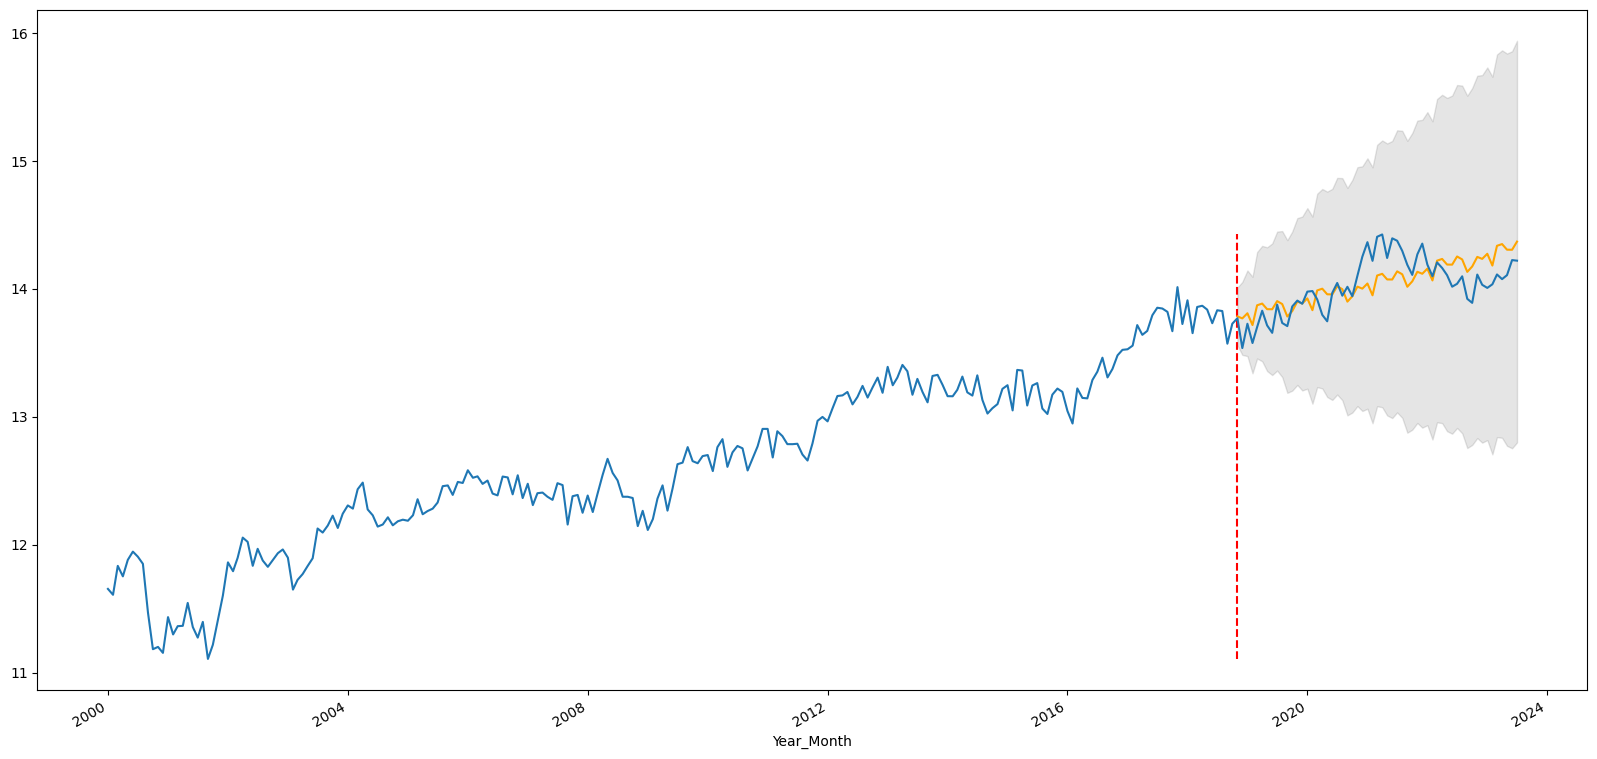

r2 score : 0.3886738586580549


In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

singlearima_process = Arima_process((0, 1, 1), (0, 1, 1, 12), train_close = train_close_data, test_close = test_close_data)

singlearima_process.drawgraph(ax)
plt.show()
print('r2 score :', singlearima_process.r2)

신뢰구간과 예측값을 확인했다. 얼추 추세가 맞는 것 같다.   
아래에는 R Square 값을 표시하게 했는데 이는 사실 활용하기 어렵다. 이유는 다변량 ARIMA에서 설명한다.

In [25]:
singlearima_process.sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 148.552
Date:                            Fri, 18 Aug 2023   AIC                           -291.105
Time:                                    12:05:18   BIC                           -281.021
Sample:                                         0   HQIC                          -287.029
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2249      0.064     -3.514      0.000      -0.350      -0.099
ma.S.L12      -0.9107      0.080    -11.332      0.000      -1.068      -0.753
sigma2         0.0132      0.001      9.211      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.98   Prob(JB):                         0.84
Heteroskedasticity (H):               0.72   Skew:                            -0.06
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

계수들의 p-value가 모두 0.05 미만이므로 해당 모델을 사용할 수 있음을 알 수 있다.

In [26]:
qf = cf.QuantFig(
    data[['Open', 'High', 'Low', 'Close']],
    title = 'Samsung Junja Rate',
    up_color = 'red',
    down_color = 'blue',
    name = 'Samsung Junja'
)

In [27]:
import plotly.graph_objs as go
from plotly.offline import plot

fig = qf.iplot(asFigure=True)
vertical_line = go.layout.Shape(
    type="line",
    x0=singlearima_process.predict_index[0],
    x1=singlearima_process.predict_index[0],
    y0=data['Low'].min(),
    y1=data['High'].max(),
    line=dict(color="green", dash="dash")
)
trend_line = go.layout.Shape(
    type="line",
    x0=singlearima_process.predict_index[0],
    x1=singlearima_process.predict_index[-1],
    y0=np.exp(singlearima_process.predicted_value[0])/22,
    y1=np.exp(singlearima_process.predicted_value[-1])/22,
    line=dict(color="orange"),
)
fig.add_shape(vertical_line)
fig.add_shape(trend_line)
plyo.iplot(fig)

그래프를 더 보기 좋게 만들어 보았다.   
하지만 이 그래프의 단점은 추세선을 직선으로 밖에 못 그린다는 것이다.

In [28]:
import plotly.graph_objects as go
import pandas as pd

# 데이터 불러오기
# Figure 생성
fig = go.Figure()

trace = go.Scatter(x=singlearima_process.predict_index, y= np.exp(singlearima_process.predicted_value)/22, mode='lines', line=dict(color="yellow") ,name='Predict Value')

vertical_line = go.layout.Shape(
    type="line",
    x0=singlearima_process.predict_index[0],
    x1=singlearima_process.predict_index[0],
    y0=data['Low'].min(),
    y1=data['High'].max(),
    line=dict(color="green", dash="dash")
)
fig.update_layout(template='plotly_dark')
fig.add_shape(vertical_line)
fig.add_trace(go.Candlestick(x=data.index,open=data['Open'],high=data['High'],low=data['Low'],close=data['Close'], name = 'sam'))
fig.update_traces(increasing_line_color= 'blue', decreasing_line_color= 'red')
fig.add_trace(trace)
fig.show(asFigure=True)

다른 그래프를 사용해서 추세선을 그려보았다.   
꽤 쓸만해 보인다.

In [29]:
fig.write_image('./plot.png')

c:\Users\chlgu\anaconda3\envs\plotly\lib\site-packages\mpl_finance.py:16: DeprecationWarning:





    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/





<class 'pandas.core.frame.DataFrame'>


c:\Users\chlgu\MyStudy\MyStudy\GongMo&Project\0731FinalProject\pyqtfile.py:416: UserWarning:

The figure layout has changed to tight



SystemExit: 0

c:\Users\chlgu\anaconda3\envs\plotly\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



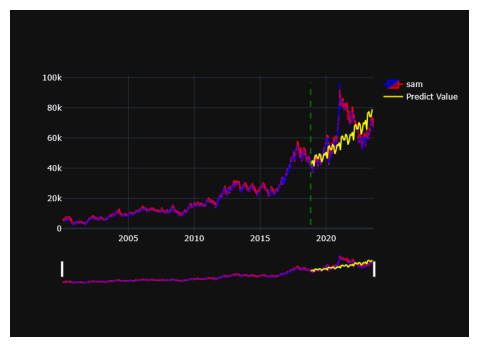

In [30]:
import pyqtfile
fig, ax = plt.subplots(1, 1)
plt.imshow(plt.imread('plot.png'))
plt.axis('off')
pyqtfile.startapp(fig)

하지만 단점으로 PyQt GUI 프로그램을 만들 시 Plotly 그래프는 사용하지 못한다.    
따라서 아쉽지만 matplotlib을 활용한 그래프 방법을 찾아야했다.

In [31]:
tempdata = pd.Series(data.index)
tempdata = tempdata[tempdata > singlearima_process.predict_index[0]]
tempdata = tempdata.apply(lambda x : x.strftime('%Y-%m'))
tempdata = tempdata.drop_duplicates(keep='last')[:-1]

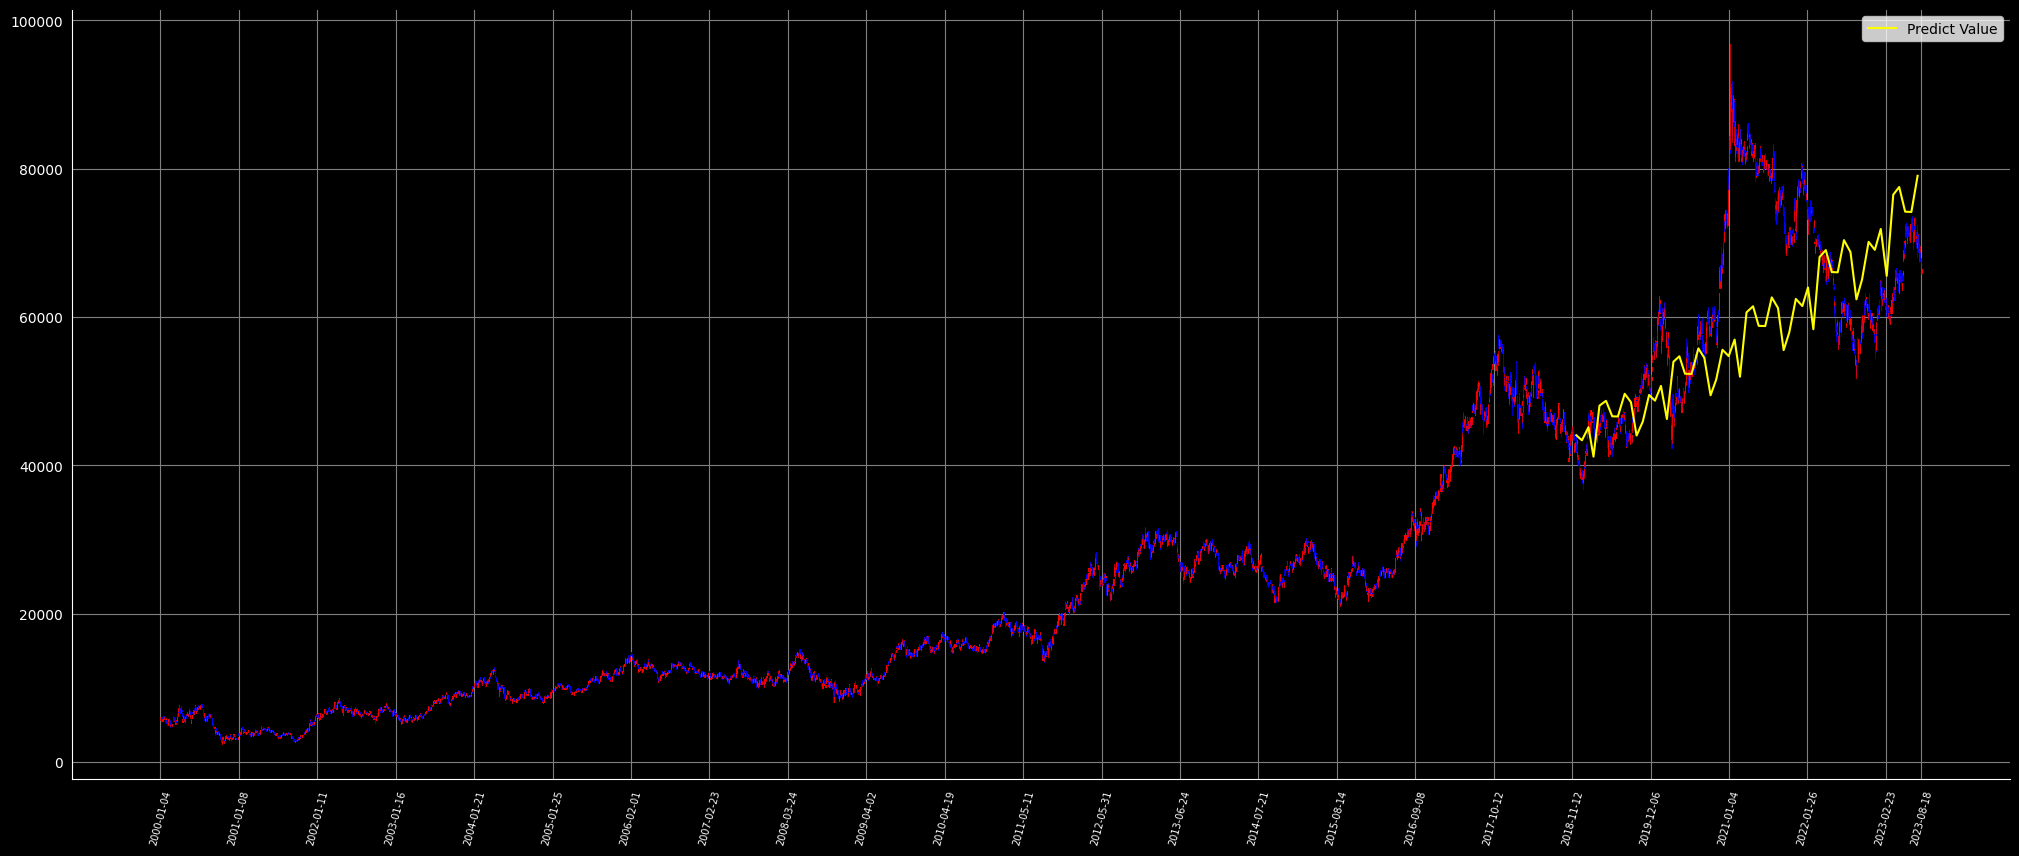

In [32]:
import mpl_finance
import mplcursors


def mapping(x):
    return data.index[round(x)].strftime('%Y-%m-%d')

fig = plt.figure(facecolor = 'black', figsize=(25, 10))

ax = fig.add_subplot(111)
ax.set_facecolor('black')
mpl_finance.candlestick2_ohlc(ax, data['Open'], data['High'], data['Low'], data['Close'], width=0.5, colorup='r', colordown='b')

x = list(range(len(data)))[::264]
x.append(len(data)-1)
xlabel = list(data.index[::264].strftime('%Y-%m-%d'))
xlabel.append(data.index[-1].strftime('%Y-%m-%d'))

ax.spines['bottom'].set_color('white')  # x축 라인
ax.spines['left'].set_color('white')    # y축 라인

cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"X : {mapping(sel.target[0])}\nY: {sel.target[1]:.2f}"))

plt.plot(tempdata.index, np.exp(singlearima_process.predicted_value)/22, color = 'yellow' ,label='Predict Value')

plt.xticks(x, xlabel, rotation = 75, color = 'white', size = 7)
plt.yticks(color='white')
plt.grid(color='gray')
plt.legend()
plt.show()

이 정도면 활용할 수 있다고 생각했다.

In [33]:
import pyqtfile
pyqtfile.startapp(fig)

c:\Users\chlgu\MyStudy\MyStudy\GongMo&Project\0731FinalProject\pyqtfile.py:416: UserWarning:

The figure layout has changed to tight

c:\Users\chlgu\anaconda3\envs\plotly\lib\site-packages\mplcursors\_pick_info.py:162: UserWarning:

Pick support for PolyCollection is missing.



SystemExit: 0

c:\Users\chlgu\anaconda3\envs\plotly\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



PyQt 프로그램에도 잘 적용됨을 확인했다.

## 3-2 MultiVariable ARIMA

다변량 ARIMA와 단변량 ARIMA의 성능을 비교하고 더 좋은 모델을 사용하기 위해 확인해본다.

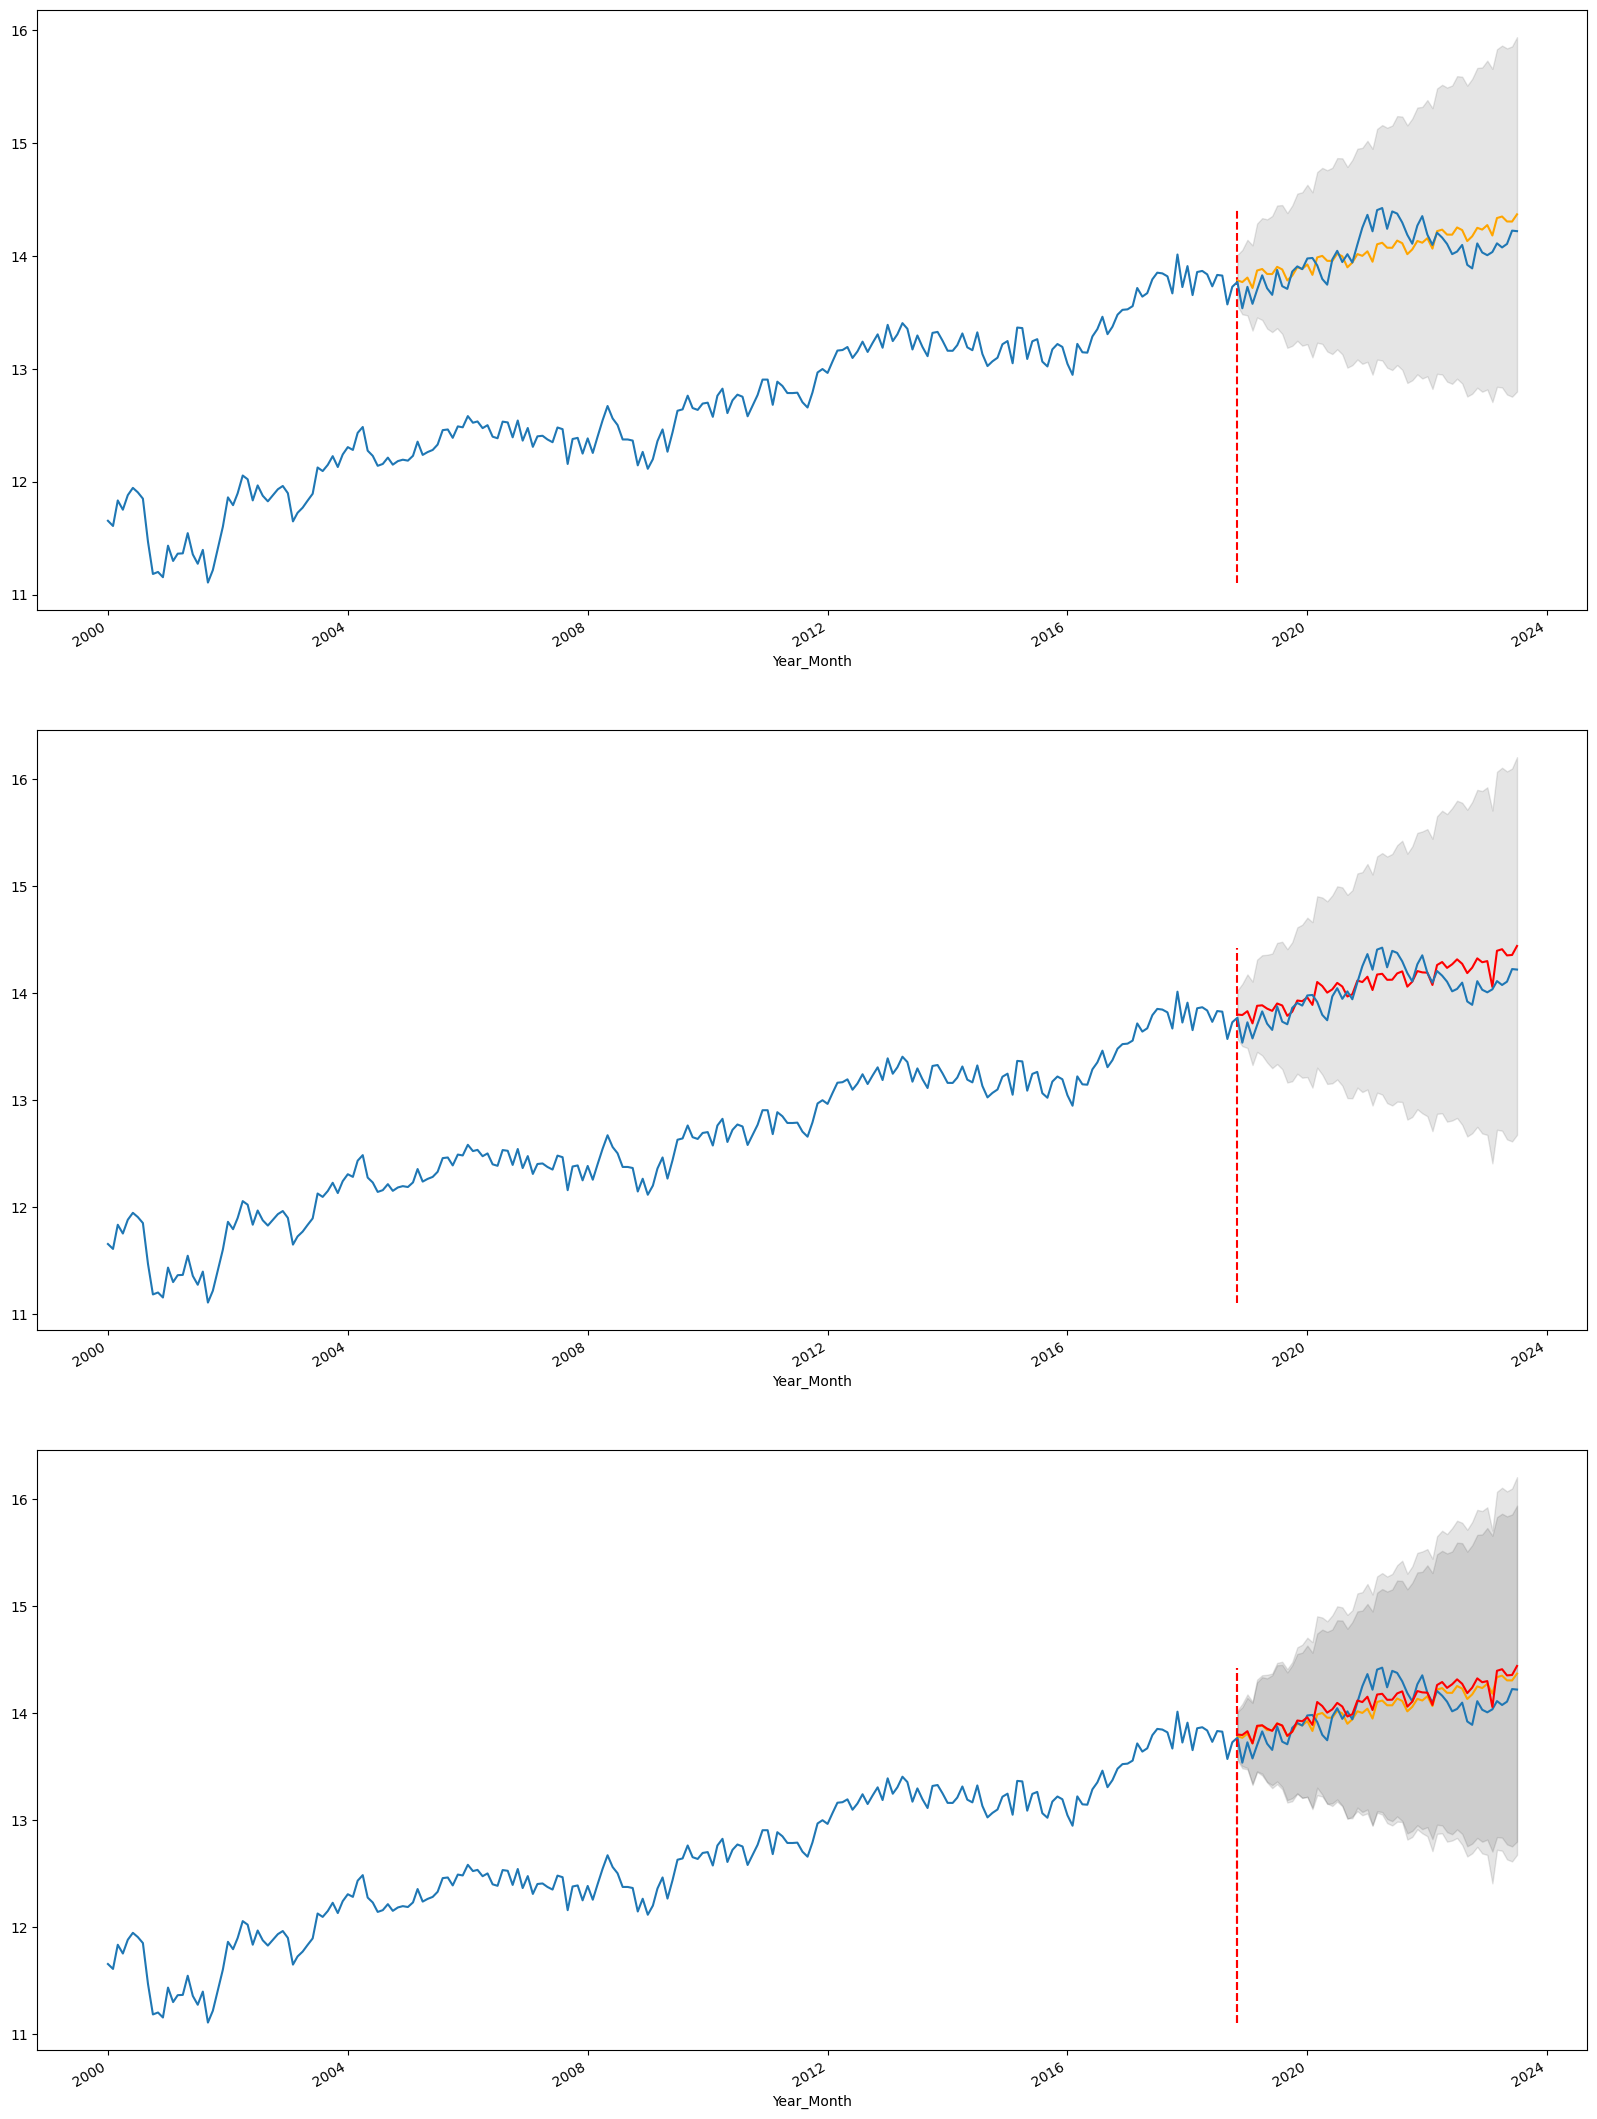

0.3886738586580549 0.362884279173018


In [34]:
fig, ax = plt.subplots(3, 1, figsize=(20, 30))

singlearima_process = Arima_process((0, 1, 1), (0, 1, 1, 12), train_close = train_close_data, test_close = test_close_data)
multiarima_process = Arima_process((0, 1, 1), (0, 1, 1, 12), bmulti = True, train_close = train_close_data, test_close = test_close_data, train_volume = train_volume_data, test_volume = test_volume_data)

singlearima_process.drawgraph(ax[0])
singlearima_process.drawgraph(ax[2])
multiarima_process.drawgraph(ax[1], 'red')
multiarima_process.drawpredictgraph(ax[2], 'red')
# Arima_process(bmulti = True).drawpredictgraph(ax)
plt.show()
print(singlearima_process.r2, multiarima_process.r2)

왼쪽 R Square 값이 단변량 ARIMA고, 오른쪽 R Square 값이 다변량 ARIMA다.   
하지만 이는 당연한 현상으로 변수가 늘어나면 R Square 값은 증가하게 되어있다.   
따라서 Adjusted R Square를 사용할까 했지만 이 또한 ARIMA의 모델 평가에서 사용하는 지표가 아니다.

In [35]:
singlearima_process.sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 148.552
Date:                            Fri, 18 Aug 2023   AIC                           -291.105
Time:                                    12:06:13   BIC                           -281.021
Sample:                                         0   HQIC                          -287.029
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2249      0.064     -3.514      0.000      -0.350      -0.099
ma.S.L12      -0.9107      0.080    -11.332      0.000      -1.068      -0.753
sigma2         0.0132      0.001      9.211      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.98   Prob(JB):                         0.84
Heteroskedasticity (H):               0.72   Skew:                            -0.06
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
multiarima_process.sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  226
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 150.399
Date:                            Fri, 18 Aug 2023   AIC                           -292.799
Time:                                    12:06:14   BIC                           -279.354
Sample:                                         0   HQIC                          -287.365
                                            - 226                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0783      0.034      2.323      0.020       0.012       0.144
ma.L1         -0.1843      0.067     -2.764      0.006      -0.315      -0.054
ma.S.L12      -0.8669      0.065    -13.267      0.000      -0.995      -0.739
sigma2         0.0132      0.001      9.666      0.000       0.011       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.98   Prob(JB):                         0.74
Heteroskedasticity (H):               0.74   Skew:                            -0.13
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA의 AIC 값을 비교한 결과 다변량 ARIMA가 모델은 더 좋음을 확인했다.   
하지만 다변량의 단점으로는 모델의 학습이 느리다는 점과 점수의 차이가 얼마 안됨을 확인하고 그냥 단변량으로 사용하기로 결정했다.

In [37]:
class Arima_process:
    def __init__(self, code):
        yf.pdr_override()
        self.data = pdr.get_data_yahoo(str(code).strip())
        dataTemp = self.data.reset_index()
        dataTemp['Year'] = dataTemp['Date'].apply(lambda x: int(str(x)[:4]))
        dataTemp['Month'] = dataTemp['Date'].apply(lambda x: int(str(x)[5:7]))
        dataTemp['Day'] = dataTemp['Date'].apply(lambda x: int(str(x)[8:10]))
        dataTemp = dataTemp[['Year', 'Month', 'Day', 'Adj Close', 'Volume', 'Open',	'High',	'Low','Close']]
        data_close = dataTemp.groupby(['Year', 'Month'])['Close'].sum().reset_index()
        data_close['Year_Month'] = data_close['Year'].astype(str) + '-' + data_close['Month'].astype(str)
        data_close['Year_Month'] = pd.to_datetime(data_close['Year_Month'])
        data_close = data_close.set_index('Year_Month')
        data_close = data_close['Close']
        data_close = data_close.iloc[:-1]
        self.data_close = data_close.apply(np.log)
        
        train_close_data, test_close_data = train_test_split(self.data_close, test_size = 0.2, shuffle=False)
        
        self.sarima_model = auto_arima(train_close_data.values, max_p=3, max_q = 3, d=1, seasonal = True, max_P = 3, max_Q=3, D=1, m=12, trace = False, error_action='ignore', suppress_warnings=False, stepwise = False)
        self.prediction = self.sarima_model.predict(len(test_close_data))
        self.predicted_value = self.prediction[0]
        # self.predicted_ub = self.prediction[1][:,0]
        # self.predicted_lb = self.prediction[1][:,1]
        self.predict_index = list(test_close_data.index)

하지만 이 또한 문제가 있었는데 ARMA 모델을 적용할 때 ACF, PACF 그래프를 통해서 결정한 것이, 자동화 그래프 그리기 프로그램에서는 사람이 결정할 수 없다는 것이다.    
따라서 이를 해결하기 위해 auto_arima라는 기능을 활용하여 Grid Search하게 만들었다.